In [1]:
!mkdir -p /content/dataset
%cd /content/dataset

!wget https://zenodo.org/record/1327317/files/training_set.zip
!wget https://zenodo.org/record/1327317/files/test_set.zip
!wget https://zenodo.org/record/1327317/files/training_set_pixel_size_and_HC.csv
!wget https://zenodo.org/record/1327317/files/test_set_pixel_size.csv

!ls -lh
!unzip training_set.zip
!unzip test_set.zip


/content/dataset
--2026-01-23 07:22:23--  https://zenodo.org/record/1327317/files/training_set.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 188.185.43.153, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1327317/files/training_set.zip [following]
--2026-01-23 07:22:24--  https://zenodo.org/records/1327317/files/training_set.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 132926838 (127M) [application/octet-stream]
Saving to: ‘training_set.zip’

training_set.zip     41%[=======>            ]  53.17M   348KB/s    eta 2m 44s ^C
--2026-01-23 07:24:23--  https://zenodo.org/record/1327317/files/test_set.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 188.185.43.153, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response...

Configuration        | MAE (mm)  
-----------------------------------
Model 1              | 28.2444
Model 2              | 28.1134
Model 3              | 27.7004


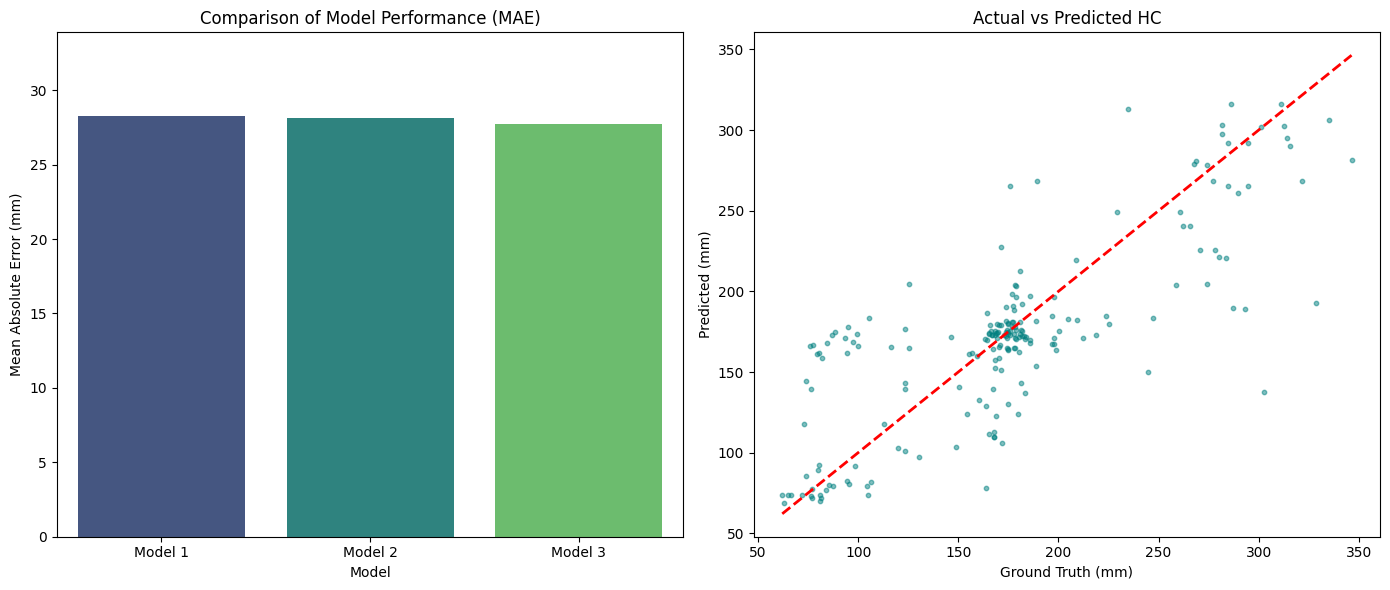

In [11]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor
train_set = pd.read_csv('/content/sample_data/training_set_pixel_size_and_HC.csv')
test_set = pd.read_csv('/content/sample_data/test_set_pixel_size.csv')
X = train_set.drop(['filename', 'head circumference (mm)'], axis=1)
y = train_set['head circumference (mm)']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=36
)

#different parameters
configs = [
    {"name": "Model 1", "n_estimators": 100, "max_depth": None, "min_samples_leaf": 1},
    {"name": "Model 2", "n_estimators": 200, "max_depth": None, "min_samples_leaf": 1},
    {"name": "Model 3", "n_estimators": 500, "max_depth": 20, "min_samples_leaf": 2}
]

results = []
predictions = {}
print(f"{'Configuration':<20} | {'MAE (mm)':<10}")
print("-" * 35)

for config in configs:
    model = RandomForestRegressor(
        n_estimators=config["n_estimators"],
        max_depth=config["max_depth"],
        min_samples_leaf=config["min_samples_leaf"],
        random_state=36,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    score = mae(y_val, y_pred)
    results.append({"Model": config["name"], "MAE": score})
    predictions[config["name"]] = y_pred

    print(f"{config['name']:<20} | {score:.4f}")


results_df = pd.DataFrame(results)
plt.figure(figsize=(14, 6))

#Performance Comparison
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='MAE', data=results_df, palette='viridis')
plt.title('Comparison of Model Performance (MAE)')
plt.ylabel('Mean Absolute Error (mm)')
plt.ylim(0, results_df['MAE'].max() * 1.2)

#Predictedvs Actual
plt.subplot(1, 2, 2)
plt.scatter(y_val, predictions["Model 2"], alpha=0.5, color='teal', s=10)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.title('Actual vs Predicted HC')
plt.xlabel('Ground Truth (mm)')
plt.ylabel('Predicted (mm)')

plt.tight_layout()
plt.show()